In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_about_pos'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5102040816326531
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4810606060606061
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.48370273794002605
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.684564424516432 	 Validation loss: 0.6832249689910371 	 
  1%|          | 574/57400 [01:21<2:00:08,  7.88it/s]
Epoch 2 	 Training loss: 0.6813692976996458 	 Validation loss: 0.6828593611717224 	 
  2%|▏         | 1148/57400 [02:43<1:51:06,  8.44it/s]
Epoch 3 	 Training loss: 0.6808600666630974 	 Validation loss: 0.6824416740465973 	 
  3%|▎         | 1722/57400 [04:05<2:12:49,  6.99it/s]
Epoch 4 	 Training loss: 0.6798568786436673 	 Validation loss: 0.681975805153281 	 
  4%|▍         | 2296/57400 [05:28<1:59:14,  7.70it/s]
Epoch 5 	 Training loss: 0.6785862167537835 	 Validation loss: 0.6800225316467932 	 
  5%|▌         | 2870/57400 [06:50<1:58:39,  7.66it/s]
Epoch 6 	 Training loss: 0.6748579907708052 	 Validation loss: 0.6726661314398555 	 
  6%|▌         | 3444/57400 [08:13<2:12:57,  6.76it/s]
Epoch 7 	 Training loss: 0.6113494637743522 	 Validation loss: 0.4874964240243879 	 
  7%|▋         | 4018/57400 [09:35<1:58:50,  7.49it/s]
Epoch 8 	 Training loss

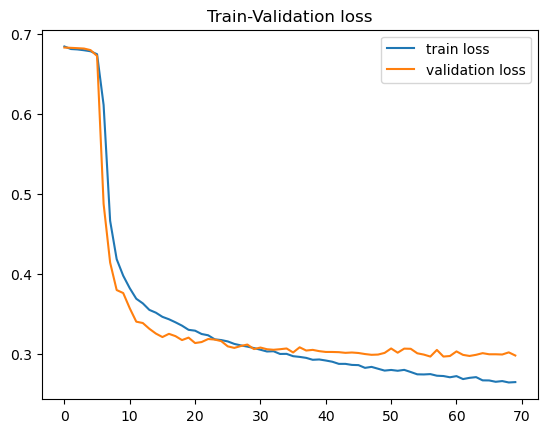

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8596938775510204
MALE 0.8723958333333334
FEMALE 0.8475 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6881313131313131
MALE 0.7104622871046229
FEMALE 0.6640419947506562 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6883963494132985
MALE 0.7070707070707071
FEMALE 0.6684636118598383 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_to_pos'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693443137801898 	 Validation loss: 0.6933977088685763 	 
  1%|          | 574/57400 [01:18<2:09:30,  7.31it/s]
Epoch 2 	 Training loss: 0.6934053455495668 	 Validation loss: 0.6933530629691431 	 
  2%|▏         | 1148/57400 [02:38<2:02:36,  7.65it/s]
Epoch 3 	 Training loss: 0.6934806861320855 	 Validation loss: 0.6940689046504134 	 
  3%|▎         | 1722/57400 [03:56<1:57:27,  7.90it/s]
Epoch 4 	 Training loss: 0.6933795796246479 	 Validation loss: 0.6931029861256227 	 
  4%|▍         | 2296/57400 [05:16<1:44:22,  8.80it/s]
Epoch 5 	 Training loss: 0.6933992390848618 	 Validation loss: 0.6933457810999983 	 
  5%|▌         | 2870/57400 [06:35<2:10:34,  6.96it/s]
Epoch 6 	 Training loss: 0.6933896868694119 	 Validation loss: 0.6929398754895744 	 
  6%|▌         | 3444/57400 [07:54<1:52:13,  8.01it/s]
Epoch 7 	 Training loss: 0.6934349591931399 	 Validation loss: 0.6929342585094904 	 
  7%|▋         | 4018/57400 [09:14<2:04:14,  7.16it/s]
Epoch 8 	 Training los

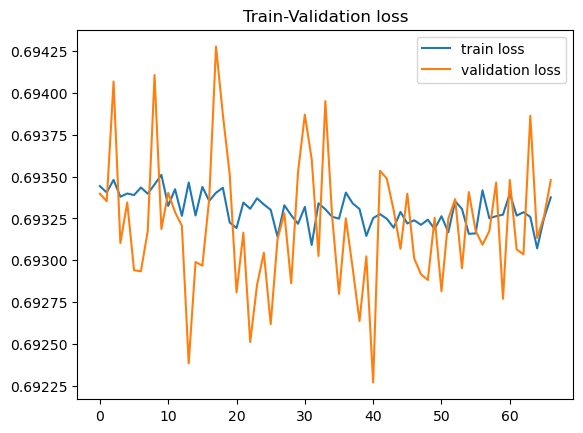

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5012755102040817
MALE 0.036458333333333336
FEMALE 0.9475 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.49242424242424243
MALE 0.06569343065693431
FEMALE 0.952755905511811 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4771838331160365
MALE 0.03282828282828283
FEMALE 0.9514824797843666 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_as_pos'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694439763287634 	 Validation loss: 0.6930224814657437 	 
  1%|          | 574/57400 [01:18<2:07:31,  7.43it/s]
Epoch 2 	 Training loss: 0.6935635299425091 	 Validation loss: 0.6927784004453885 	 
  2%|▏         | 1148/57400 [02:38<2:11:55,  7.11it/s]
Epoch 3 	 Training loss: 0.6934246916181119 	 Validation loss: 0.6925787713568089 	 
  3%|▎         | 1722/57400 [03:57<2:02:10,  7.60it/s]
Epoch 4 	 Training loss: 0.6934410120759692 	 Validation loss: 0.6924388731940317 	 
  4%|▍         | 2296/57400 [05:17<2:11:39,  6.98it/s]
Epoch 5 	 Training loss: 0.693358908027722 	 Validation loss: 0.692544810852762 	 
  5%|▌         | 2870/57400 [06:36<1:54:32,  7.93it/s]
Epoch 6 	 Training loss: 0.6932963151549628 	 Validation loss: 0.6930553862604044 	 
  6%|▌         | 3444/57400 [07:55<1:50:16,  8.16it/s]
Epoch 7 	 Training loss: 0.6933496589236974 	 Validation loss: 0.6930902085061801 	 
  7%|▋         | 4018/57400 [09:14<1:47:44,  8.26it/s]
Epoch 8 	 Training loss:

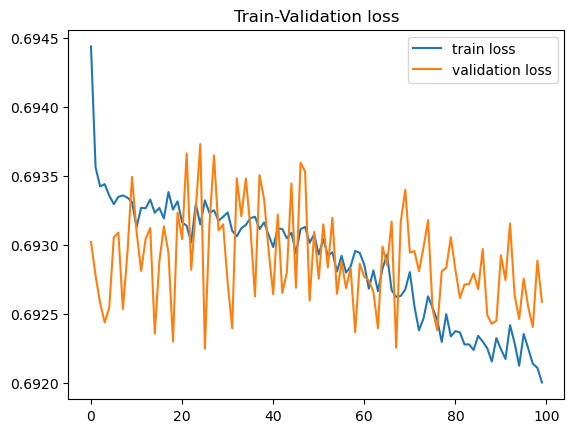

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:

model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5051020408163265
MALE 0.109375
FEMALE 0.885 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4734848484848485
MALE 0.09002433090024331
FEMALE 0.8871391076115486 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5045632333767927
MALE 0.13383838383838384
FEMALE 0.9002695417789758 

